In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from models.prepareData import getData, convertData, calcMinimumMaximum
from models.models import linearRegressionModel, PolynomialFeatures, lassoRegressionModel, ridgeRegressionModel 

In [2]:
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Thọ', 'Phước Kiển', 'Nhà Bè')
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Cảnh', '22', 'Bình Thạnh')
# data = getData('Bán đất', 'Trần Văn Giàu', 'Lê Minh Xuân', 'Bình Chánh')
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Phạm Văn Chiêu', '9', 'Gò Vấp')
# data = getData('Bán nhà riêng', 'Nguyễn Văn Quá', 'Đông Hưng Thuận', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')
# data = getData('Bán đất', 'Tôn Đản', '10', '4')
# data = getData('Bán căn hộ chung cư', '9A', 'Bình Hưng', 'Bình Chánh')
data = getData('Bán nhà riêng', 'Cao Thắng', '12', '10')
# data = getData('Bán đất', 'Bà Thiên', 'Nhuận Đức', 'Củ Chi')

In [3]:
post_type = data['post_type'].iloc[0]
street = data['street'].iloc[0]
ward = data['ward'].iloc[0]
district = data['district'].iloc[0]

In [4]:
print("Data length: ", len(data))

Data length:  59


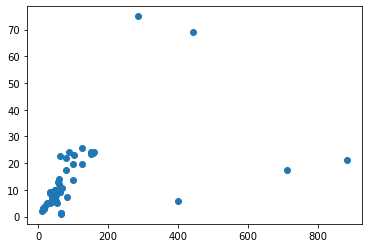

In [5]:
plt.scatter(data['area'], data['price'])
plt.show()

In [6]:
data = data[~(data['area'] < 10)]
data = data[~(data['price'] > 200)]

In [7]:
print("Data length: ", len(data))

Data length:  59


In [8]:
# transform data into log1p
data['area'] = (data['area']).transform(np.log1p)
data['price'] = (data['price']).transform(np.log1p)

In [9]:
# Instead of drop duplicates try calc and use its mean value:
data = data.groupby(['area'], as_index=False).mean()

# sort data by area:
data = data.sort_values(by=['area'])

In [10]:
area_mean = np.mean(data['area'])
area_std = np.std(data['area'])

price_mean = np.mean(data['price'])
price_std = np.std(data['price'])

data = data[~( (data['area'] < area_mean) & (data['price'] > price_mean) )]
data = data[~( (data['area'] > area_mean) & (data['price'] < price_mean - price_std) )]

In [11]:
# # remove outliers using box-plot:
# while True:
#     area_minimum, area_maximum = calcMinimumMaximum(data['area'])
#     if (data['area'] > area_minimum).all() and (data['area'] < area_maximum).all():
#         break
#     else:
#         data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

# while True:
#     price_minimum, price_maximum = calcMinimumMaximum(data['price'])
#     if (data['price'] > price_minimum).all() and (data['price'] < price_maximum).all():
#         break
#     else:
#         data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [12]:
# area_minimum, area_maximum = calcMinimumMaximum(data['area'])
# data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

# price_minimum, price_maximum = calcMinimumMaximum(data['price'])
# data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [13]:
# data = data[(data['area'] > 5.5)]

In [14]:
print("Data length: ", len(data))

Data length:  41


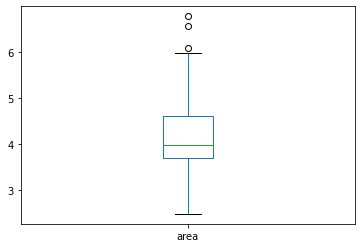

In [15]:
data['area'].plot(kind='box')
plt.show()

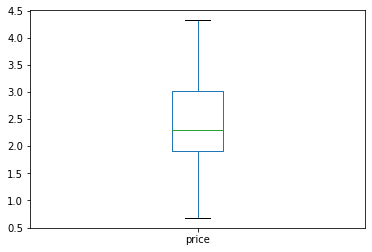

In [16]:
data['price'].plot(kind='box')
plt.show()

In [17]:
print("Data length: ", len(data))

Data length:  41


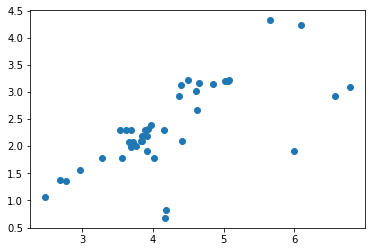

In [18]:
plt.scatter(data['area'], data['price'])
plt.show()

In [19]:
from sklearn.neighbors import LocalOutlierFactor

# convert dataframe into numpy array:
X = data.to_numpy()
n_neighbors = 10

In [20]:
X

array([[2.4765384 , 1.06471074],
       [2.68102153, 1.38629436],
       [2.77258872, 1.36097655],
       [2.9601051 , 1.56861592],
       [3.28091122, 1.79175947],
       [3.52636052, 2.29588487],
       [3.55820113, 1.79175947],
       [3.61091791, 2.30258509],
       [3.65842025, 2.07944154],
       [3.68386691, 1.98787435],
       [3.68887945, 2.30258509],
       [3.71357207, 2.07709228],
       [3.76120012, 2.00148   ],
       [3.8286414 , 2.10413415],
       [3.83729946, 2.10413415],
       [3.8501476 , 2.19722458],
       [3.8918203 , 2.3067384 ],
       [3.91402101, 2.19722458],
       [3.91800508, 1.92308739],
       [3.93182563, 2.31784252],
       [3.97029191, 2.38876279],
       [4.01096295, 1.79175947],
       [4.15888308, 2.30258509],
       [4.17438727, 0.67803354],
       [4.18965474, 0.82855182],
       [4.36944785, 2.92316158],
       [4.40182926, 3.13549422],
       [4.40427724, 2.10413415],
       [4.48863637, 3.21887582],
       [4.61015773, 3.02042489],
       [4.


Outliers detected by Local Outlier Factor with n_neighbors =  10


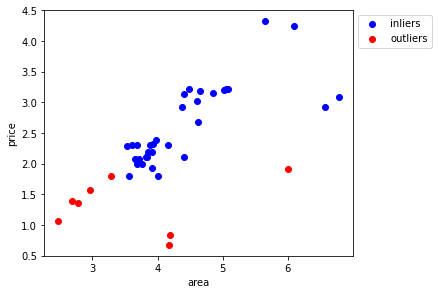

In [21]:
isNeighbors = LocalOutlierFactor(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean', contamination=0.2).fit_predict(X)

# locate outliers by index:
outlier_indexes = np.where(isNeighbors == -1)
outlier_values = data.iloc[outlier_indexes]

# drop outliers:
data = data.drop(outlier_values.index)

print("\nOutliers detected by Local Outlier Factor with n_neighbors = ", n_neighbors)
# plot outliers removed:
plt.scatter(data['area'], data['price'], color='blue', label='inliers')
plt.scatter(outlier_values['area'], outlier_values['price'], color='red', label='outliers')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [22]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=4)
test_data, validate_data = train_test_split(test_data, test_size=0.5, random_state=4)

In [23]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])
validate_data = validate_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))
print("Validate data length: ", len(validate_data))


Train data length:  23
Test data length:  5
Validate data length:  5


In [24]:
# # convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)
X_validate, Y_validate = convertData(validate_data)

Text(0.5, 1.0, 'Y_validate')

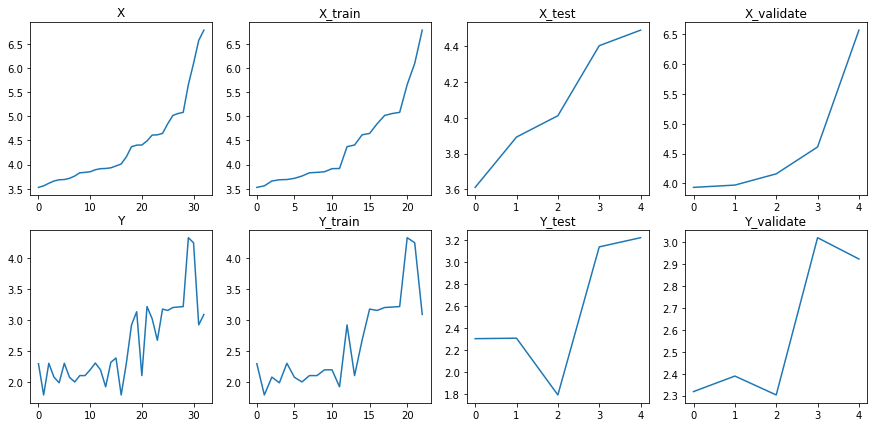

In [25]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0][0].plot(X)
ax[0][0].set_title('X')
ax[0][1].plot(X_train)
ax[0][1].set_title('X_train')
ax[0][2].plot(X_test)
ax[0][2].set_title('X_test')
ax[0][3].plot(X_validate)
ax[0][3].set_title('X_validate')

ax[1][0].plot(Y)
ax[1][0].set_title('Y')
ax[1][1].plot(Y_train)
ax[1][1].set_title('Y_train')
ax[1][2].plot(Y_test)
ax[1][2].set_title('Y_test')
ax[1][3].plot(Y_validate)
ax[1][3].set_title('Y_validate')

In [26]:
# find model by using linear regression:
linear_regression_model = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = linear_regression_model.predict(X_train)
Y_test_pred = linear_regression_model.predict(X_test)

# Calculate RMSE on train and test data:
train_linear_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
test_linear_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))


Linear Regression Model: 


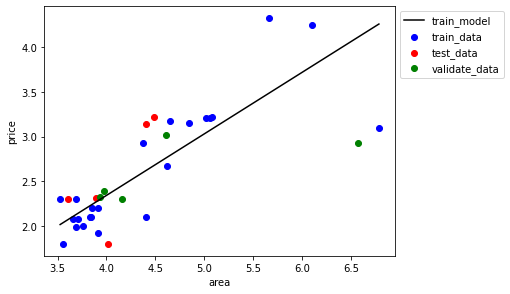

In [27]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [28]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(linear_regression_model.coef_))
print("Linear model intercept: {}".format(linear_regression_model.intercept_))

# linear_model rmse:
print("Linear model rmse on train data: {}".format(train_linear_rmse))
print("Linear model rmse on test data: {}".format(test_linear_rmse))
print("\n\n")

Linear model coefficient: [[0.68915192]]
Linear model intercept: [-0.41532726]
Linear model rmse on train data: 0.3815306168144104
Linear model rmse on test data: 0.4300439171458325





In [29]:
def calcRMSE(model, X, Y):
    return np.sqrt(mean_squared_error(Y, model.predict(X)))

def calcCV(model, X, Y, scoring):
    return np.mean(cross_val_score(model, X, Y, scoring=scoring, cv=5))

## Polynomial Regression Model

In [30]:
def polynomialTransform(dataset, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    dataset_poly = polynomial_features.fit_transform(dataset)
    return dataset_poly

In [31]:
# degree = 2
X_train_poly = polynomialTransform(X_train, 2)
selected_poly_model = linearRegressionModel(X_train_poly, Y_train)

# calc rmse on validate data:
X_validate_poly = polynomialTransform(X_validate, 2)
min_poly_rmse = calcRMSE(selected_poly_model, X_validate_poly, Y_validate)

# Choose model with specific degree:
selected_degree = 2
selected_X_train_poly = X_train_poly

min_degree = 3
max_degree = 100

for i in range(min_degree, max_degree+1):
    X_train_poly = polynomialTransform(X_train, i)
    poly_model = linearRegressionModel(X_train_poly, Y_train)

    # calc rmse on validate data:
    X_validate_poly = polynomialTransform(X_validate, i)
    rmse = calcRMSE(poly_model, X_validate_poly, Y_validate)

    # Try to select the model with minimum rmse:
    if rmse < min_poly_rmse:
        min_poly_rmse = rmse
        selected_poly_model = poly_model
        selected_X_train_poly = X_train_poly
        selected_degree = i
        
print("Polynomial Regression with degree = ", selected_degree)
print("RMSE on validate data: ", min_poly_rmse)
print("Polynomial model coefficient:")
print(selected_poly_model.coef_)
print("Polynomial model intercept: {}\n".format(selected_poly_model.intercept_))

# Predict Y:
Y_train_poly_pred = selected_poly_model.predict(selected_X_train_poly)

Polynomial Regression with degree =  13
RMSE on validate data:  0.2320565582672758
Polynomial model coefficient:
[[ 0.00000000e+00 -6.38941777e+01 -1.71189867e+02 -2.62463382e+02
  -1.84977370e+02  1.11965874e+02  2.16270901e+02 -2.29739961e+02
   1.01450774e+02 -2.56490360e+01  3.99802067e+00 -3.81805918e-01
   2.05764092e-02 -4.80832647e-04]]
Polynomial model intercept: [2007.27521084]



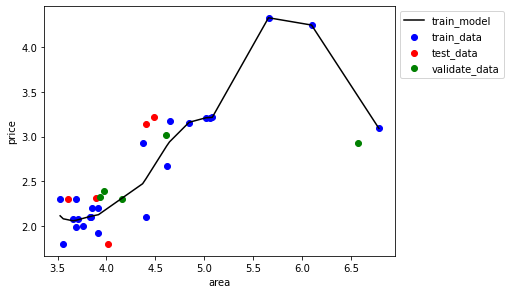

In [32]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_poly_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

### Alpha Hyperparameter

In [33]:
alphas = [0.00001, 0.00003, 0.00005, 0.00008, 0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.1, 1.0, 3.0, 5.0, 10.0, 50.0, 100.0]

In [34]:
X_validate_poly = polynomialTransform(X_validate, selected_degree)

In [35]:
# ignore warnings: =))) 
import warnings

## Ridge Regression Model

In [36]:
selected_ridge_alpha = alphas[0]
warnings.filterwarnings('ignore')

ridge_model = linear_model.Ridge(alpha=selected_ridge_alpha, fit_intercept=True, normalize=True, max_iter=2000, tol=0.001)
max_ridge_cv_score = calcCV(ridge_model, selected_X_train_poly, Y_train, 'r2')

for alpha in alphas[1:]:
    ridge_model = linear_model.Ridge(alpha=alpha, fit_intercept=True, normalize=True, max_iter=2000, tol=0.001)

    ridge_cv_score = calcCV(ridge_model, selected_X_train_poly, Y_train, 'r2')

    if ridge_cv_score > max_ridge_cv_score:
        max_ridge_cv_score = ridge_cv_score
        selected_ridge_alpha = alpha
        
# fit model with selected alpha:
ridge_model = ridgeRegressionModel(selected_X_train_poly, Y_train, selected_ridge_alpha)

# RMSE:
ridge_rmse = calcRMSE(ridge_model, X_validate_poly, Y_validate)

print("Ridge Regression with alpha = {} and RMSE = {}".format(selected_ridge_alpha, ridge_rmse))
print("Ridge Regression coefficient:")
print(ridge_model.coef_)
print("Ridge Regression intercept: ", ridge_model.intercept_)

# Predict Y with Ridge:
Y_train_ridge_pred = ridge_model.predict(selected_X_train_poly)

Ridge Regression with alpha = 0.06 and RMSE = 0.3942295775690423
Ridge Regression coefficient:
[[ 0.00000000e+00  2.64675521e-01  2.75470186e-02  3.40800518e-03
   4.21140242e-04  4.85362720e-05  4.85701432e-06  3.45914678e-07
  -5.39065639e-09 -9.00329526e-09 -2.48146399e-09 -5.23937531e-10
  -9.84841678e-11 -1.73320144e-11]]
Ridge Regression intercept:  [0.40774839]


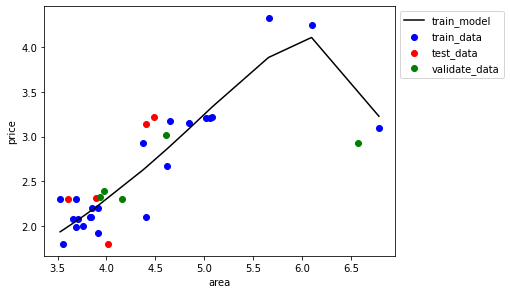

In [37]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_ridge_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

## Lasso Regression Model

In [38]:
selected_lasso_alpha = alphas[0]
warnings.filterwarnings('ignore')

lasso_model = linear_model.Lasso(alpha=selected_lasso_alpha, fit_intercept=True, normalize=True, max_iter=2000, tol=0.001)
max_lasso_cv_score = calcCV(lasso_model, selected_X_train_poly, Y_train, 'r2')

for alpha in alphas[1:]:
    lasso_model = linear_model.Lasso(alpha=alpha, fit_intercept=True, normalize=True, max_iter=2000, tol=0.001)
    lasso_cv_score = calcCV(lasso_model, selected_X_train_poly, Y_train, 'r2')

    if lasso_cv_score > max_lasso_cv_score:
        max_lasso_cv_score = lasso_cv_score
        selected_lasso_alpha = alpha
        
# Fit model with selected alpha:
lasso_model = lassoRegressionModel(selected_X_train_poly, Y_train, selected_lasso_alpha)
lasso_rmse = calcRMSE(lasso_model, X_validate_poly, Y_validate)

print("Lasso Model with alpha = {} and RMSE = {}".format(selected_lasso_alpha, lasso_rmse))
print("Lasso Regression coefficient:")
print(lasso_model.coef_)
print("Lasso Regression intercept: ", lasso_model.intercept_)

# Predict Y with Ridge:
Y_train_lasso_pred = lasso_model.predict(selected_X_train_poly)

Lasso Model with alpha = 0.005 and RMSE = 0.36016276426101695
Lasso Regression coefficient:
[ 0.00000000e+00  8.93718281e-01  5.64956837e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -2.57293399e-11]
Lasso Regression intercept:  [-1.32795386]


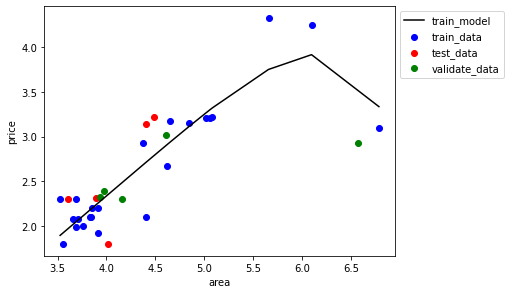

In [39]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_lasso_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [40]:
# score the model with test data:
X_test_poly = polynomialTransform(X_test, selected_degree)

# Linear score:
print("\n")

linear_train_r2_score = linear_regression_model.score(X_train, Y_train)
print("Linear Model score on train dataset: ", linear_train_r2_score)

linear_test_r2_score = linear_regression_model.score(X_test, Y_test)
print("Linear Model score on test dataset: ", linear_test_r2_score)

# Poly score:
print("\n")

poly_train_r2_score = selected_poly_model.score(selected_X_train_poly, Y_train)
print("Poly Model score on train dataset: ", poly_train_r2_score)

poly_test_r2_score = selected_poly_model.score(X_test_poly, Y_test)
print("Poly Model score on test dataset: ", poly_test_r2_score)

# Ridge score:
print("\n")

ridge_train_r2_score = ridge_model.score(selected_X_train_poly, Y_train)
print("Ridge Model score on train dataset: ", ridge_train_r2_score)

ridge_test_r2_score = ridge_model.score(X_test_poly, Y_test)
print("Ridge Model score on test dataset: ", ridge_test_r2_score)

# Lasso score:
print("\n")

lasso_train_r2_score = lasso_model.score(selected_X_train_poly, Y_train)
print("Lasso Model score on train dataset: ", lasso_train_r2_score)

lasso_test_r2_score = lasso_model.score(X_test_poly, Y_test)
print("Lasso Model score on test dataset: ", lasso_test_r2_score)



Linear Model score on train dataset:  0.7074678779953794
Linear Model score on test dataset:  0.3775282865223346


Poly Model score on train dataset:  0.9362671929529799
Poly Model score on test dataset:  0.40029267614608344


Ridge Model score on train dataset:  0.902049022714151
Ridge Model score on test dataset:  0.43706923804528364


Lasso Model score on train dataset:  0.8721131250035957
Lasso Model score on test dataset:  0.4703247382080801


In [41]:
# # calc cross validation score of linear to compare with poly for best model selection
# linear_cv = np.mean(cross_val_score(linear_model, X, Y, cv=5))
# poly_cv = np.mean(cross_val_score(poly_model, X, Y, cv=5))

# best_r2_score = linear_test_r2_score if linear_test_r2_score > poly_test_r2_score else poly_test_r2_score
# best_model = linear_model if linear_cv > poly_cv else poly_model
# best_degree = 1 if linear_cv > poly_cv else degree

# print(linear_cv)
# print(poly_cv)

In [42]:
import unidecode
post_type = unidecode.unidecode(post_type.lower().replace(" ", ""))
street = unidecode.unidecode(street.lower().replace(" ", ""))
ward = unidecode.unidecode(ward.lower().replace(" ", ""))
district = unidecode.unidecode(district.lower().replace(" ", ""))
model_name = post_type + "_" + street + "_" + ward + "_" + district

In [43]:
model_name

'bannharieng_caothang_12_10'

In [44]:
# # Save model after training for later use:
# from joblib import dump, load

# if best_r2_score > 0.7:
#     # Save model:
#     dump((best_model, best_degree), 'trained\\' + model_name + '.joblib')

In [45]:
# try:    
#     # load model:
#     loaded_model, loaded_degree = load('trained/' + model_name + ".joblib")

#     test_area = np.array([92.00])
#     test_area = test_area[:, np.newaxis]
#     test_area = FunctionTransformer(np.log1p).fit_transform(test_area)

#     if loaded_degree == 1:
#         predicted_price = loaded_model.predict(test_area)
#     else:
#         test_area_poly = PolynomialFeatures(degree=loaded_degree).fit_transform(test_area)
#         predicted_price = loaded_model.predict(test_area_poly)

#     print(FunctionTransformer(np.log1p).inverse_transform(predicted_price))
# except FileNotFoundError:
#     print("Model not found or trained result is low!")